# Implementing ZFNet

In this paper implementation, we are going to implement **ZFNet** from the paper **Visualizing and Understanding Convolutional Networks** by **Matthew D Zeiler, Rob Fergus**

This paper utilizes **Deconvolution** which also introduced in the paper **Deconvolutional Network** (deconvnet) (Zeiler et al., 2011)

This produces visualizations per layer of the activations produced by specific Convolution layers on a particular Neural Network

![Sample Deconvolution](images/sample_deconv.png)

Also, I've used AlexNet (Krizhevsky et al., 2012) again here since the original paper uses it as their architecture of choice.

## Implementation Details

#### Python Libraries
- Pytorch
- Torchvision, Torchtext (For download utilities)
- TorchInfo (for summarizing models)
- Numpy
- Matplotlib
- Seaborn

### Hardware Used

**GPU** : NVIDIA RTX 3060

#### Dataset Used
- [Kaggle Cats and Dogs Dataset](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

#### References
- [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901) (Original Paper)


In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
import torch.nn.functional as F

import torch.nn as nn

from torch.utils.data import DataLoader, random_split

In [3]:
from collections import OrderedDict

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [5]:
import torch.optim as optim


In [6]:
from PIL import Image
from random import shuffle
import json
import os
import numpy as np

### Helper Class for Cats VS Dogs Dataset
- This is a custom class I've written for preprocessing, cleaning the cats and dogs dataset. Stored in `download_cats_dogs.py`

In [7]:
from download_cats_dogs import CatDogDataset, make_dir

In [8]:
cats_dogs_dataset = CatDogDataset(download_root='../dataset', keep_zip=True)

In [9]:
train_dir, test_dir = cats_dogs_dataset.prepocess_files()

Files already preprocessed. No need to preprocess again.


### Data Augmentation
- We'll use a straight forward data augmentation of Random Resized Crop and Random Horizontal Flipping with Color Jittering

In [ ]:
def convert_type(y):
    return torch.tensor(y, dtype=torch.float32)

In [175]:
train_transforms = transforms.Compose([

    transforms.RandomResizedCrop(224, interpolation=Image.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(
        [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                saturation=0.2, hue=0.1)],
        p=0.8
    ),
    
    transforms.ToTensor(),

])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])





### Data Loaders
- Since our helper class produces the `train_dir` and `test_dir` of our preprocessed images. We can use them directly to `ImageFolder` and `DataLoader` Pytorch class

In [ ]:
tr_ds = ImageFolder(train_dir, transform=train_transforms, target_transform=convert_type)
ts_ds = ImageFolder(test_dir, transform=test_transforms, target_transform=convert_type)

tr_dl = DataLoader(tr_ds, batch_size=32, shuffle=True)
ts_dl = DataLoader(ts_ds, batch_size=32, shuffle=True)


In [12]:
def json_to_ordered_dict(path):
    with open(path, 'r') as f:
        d = json.load(f)
        return OrderedDict(sorted(d.items()))
    return []

### Before we go to the Architecture, let's get things straight first

ZFNet paper uses Deconvolution. Specifically, we would want to like to use some approximate inverse-function of the following CNN layers like:

- Convolution Layer inverts to Convolution Transpose Layer
- Maxpooling inverts to Unpooling

Now, take note that they don't do an exact inverse, but rather an approximate.

Here are the descriptions in the paper that may prove useful.


**Unpooling:** In the convnet, the max pooling operation is non-invertible, however we can obtain an ap-
proximate inverse by recording the locations of the maxima within each pooling region in a set of switch
variables. In the deconvnet, the unpooling operation uses these switches to place the reconstructions from
the layer above into appropriate locations, preserving the structure of the stimulus.

**Rectification:** The convnet uses relu non-linearities, which rectify the feature maps thus ensuring the fea-
ture maps are always positive. To obtain valid feature reconstructions at each layer (which also should
be positive), we pass the reconstructed signal through a relu non-linearity.

**Filtering:** The convnet uses learned filters to convolve the feature maps from the previous layer. To invert this, the deconvnet uses transposed versions of the same filters, but applied to the rectified maps, not
the output of the layer beneath. In practice this means flipping each filter vertically and horizontally.
Projecting down from higher layers uses the switch settings generated by the max pooling in the convnet
on the way up. As these switch settings are peculiar to a given input image, the reconstruction obtained
from a single activation thus resembles a small piece of the original input image, with structures weighted
according to their contribution toward to the feature activation. Since the model is trained discriminatively,
they implicitly show which parts of the input image are discriminative. Note that these projections are not
samples from the model, since there is no generative process involved.


### Available Implemented layers in Pytorch
Luckily, `Pytorch` provides layers for these already, namely `nn.ConvTranspose2d` and `nn.MaxUnpool2d`. We will utilize this and we would utilize these layers to implement ZFNet


### Now with the ZFNet Architecture

#### Design Principles

Typically, AlexNet CNNs follows this sequence of SubNetworks

```
(Convnet) -> (ReLU) -> (MaxPool)

```
We can exploit this by wrapping them in another class that subclasses `nn.Module` and pair them with corresponding `nn.ConvTranspose2d` and `nn.MaxUnpool2d`, and we should add an important component which ZFNet paper calls switch_index, which contains the indices that a MaxPool layer choses.

Wrapping these components to a specific module makes referencing to the switch_indices easier as well. so let's implement these on the `ConvDeconv(nn.Module)` class


Typically, a Pytorch network, involves a `forward(x)` pass. Here, we would also include a `forward_deconv(x)` which triggers deconvolution.

In [13]:
class ConvDeconv(nn.Module):
    
    def __init__(self, in_channel, 
                       out_channel, 
                       conv_kernel_size,
                       conv_stride, 
                       conv_padding,
                       pool_kernel_size=None,
                       pool_stride=None,
                       pool_padding=None,
                       has_pooling=True,
                       has_last_out=False):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channel, out_channel, 
                              kernel_size=conv_kernel_size,
                              stride=conv_stride, 
                              padding=conv_padding)
        
        
        self.bnorm = nn.BatchNorm2d(out_channel)
        
        self.deconv = nn.ConvTranspose2d(out_channel, in_channel, 
                                         kernel_size=conv_kernel_size, 
                                         stride=conv_stride, 
                                         padding=conv_padding, bias=False)
        
        self.has_pooling = has_pooling
        
        if self.has_pooling:
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, 
                                     stride=pool_stride, 
                                     padding=pool_padding, 
                                     return_indices=True)
            
            self.depool = nn.MaxUnpool2d(kernel_size=pool_kernel_size, 
                                         stride=pool_stride, 
                                         padding=pool_padding)    
        self.has_forward = False
        self.has_last_out = has_last_out
        
    def forward_update(self, func, x):
        x = func(x)
        self.last_shape = x.shape
        return x
        
    def forward(self, x):
        
        self.has_forward = True
        
        x = self.forward_update(self.conv, x)
        x = self.forward_update(F.relu, x)
        x = self.bnorm(x)
        
        if self.has_pooling:
            x, switch_index = self.pool(x)
            self.switch_index=switch_index
        
        if self.has_last_out:
            self.last_out = x
            
        return x
    
    def forward_deconv(self, x):
        
        assert self.has_forward, 'Invoke Forward Propagation first'
        
        if self.has_pooling:
            x = self.depool(x, self.switch_index, output_size=self.last_shape[-2:])
        
        x = F.relu(x)
        x = self.deconv(x)
        
        return x

### Storing the configuration of ZFNet
Since this implementation of `ZFNet` uses multiple layers of `ConvDeconv` layers, I've decided to store the configuration in a json file. So we'll make our code less cluttered. Let's view what's inside the configuration file `conv_config.json`

In [183]:
json_to_ordered_dict('conv_config.json')

OrderedDict([('conv_deconv_01',
              {'in_channel': 3,
               'out_channel': 96,
               'conv_kernel_size': 7,
               'conv_stride': 2,
               'conv_padding': 1,
               'pool_kernel_size': 3,
               'pool_stride': 2,
               'pool_padding': 1,
               'has_pooling': True,
               'has_last_out': False}),
             ('conv_deconv_02',
              {'in_channel': 96,
               'out_channel': 256,
               'conv_kernel_size': 5,
               'conv_stride': 2,
               'conv_padding': 0,
               'pool_kernel_size': 3,
               'pool_stride': 2,
               'pool_padding': 1,
               'has_pooling': True,
               'has_last_out': False}),
             ('conv_deconv_03',
              {'in_channel': 256,
               'out_channel': 384,
               'conv_kernel_size': 3,
               'conv_stride': 1,
               'conv_padding': 1,
               'has_pool

In [14]:
# Main architecture
class ZFNet(nn.Module):
            
    def __init__(self, conv_config_path):
        super().__init__()
        self.backbone = self.create_conv_seq(conv_config_path)
        self.linear = nn.Sequential(
                nn.Flatten(),
                nn.Dropout(0.1),
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(),
                nn.BatchNorm1d(4096),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.BatchNorm1d(4096),
                nn.Linear(4096, 1),
                nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.linear(x)
        return torch.squeeze(x)
        
    def forward_deconv(self, layer_num):
        x = self.backbone[-1].last_out
        
        for layer_count, layer in enumerate(reversed(self.backbone), start=1):
            x = layer.forward_deconv(x)
            if layer_count >= layer_num:
                return x
            
        return x
        
    def create_conv_seq(self, conv_config_path):
        
        config = json_to_ordered_dict(conv_config_path)
        od_list = [(layer_name, ConvDeconv(**layer_args)) for layer_name, layer_args in config.items()]
        
        return nn.Sequential(OrderedDict(od_list))
   

In [15]:
def accuracy_metric(target, prediction, thresh=0.5):
    
    pred_round = torch.where(prediction > thresh, 1.0, 0.0)
    res = (target == pred_round).to(torch.int32)
    
    return torch.sum(res) / res.shape[0]
    

In [16]:
import pandas as pd

def compile_history(epoch_list, 
                    train_loss_per_epoch, 
                    train_accuracy_per_epoch,
                    test_loss_per_epoch,
                    test_accuracy_per_epoch):
    
    json_list = []
    
    for epoch, train_loss, train_acc, test_loss, test_acc in zip(epoch_list,
                                                                 train_loss_per_epoch,
                                                                 train_accuracy_per_epoch,
                                                                 test_loss_per_epoch,
                                                                 test_accuracy_per_epoch):
        
        json_list.append({
            'epoch' : epoch,
            'train_loss' : train_loss,
            'train_acc' : train_acc,
            'test_loss' : test_loss,
            'test_acc' : test_acc
        })
        
    return pd.DataFrame(json_list)




def train_model(model, 
                criterion, 
                optimizer,
                train_dataloader,
                test_dataloader,
                device, 
                model_path, 
                num_epoch=5,
                patience=5):
    
    
    print('Training Model for ZFNet')
    
    print('Device: ', device)
    print('Batch Size: ', train_dataloader.batch_size)
    print('Train Total Batches: ', len(train_dataloader))
    print('Test Total Batches: ', len(test_dataloader))
    print('Model Path: ', model_path)
    print('Number of Epochs: ', num_epoch)
    print('Patience: ', patience)
    print(' ')
    
    
    epoch_list = []
    train_loss_per_epoch = []
    train_accuracy_per_epoch = []
    
    test_loss_per_epoch = []
    test_accuracy_per_epoch = []
    
    total_train_batch = len(train_dataloader)
    total_test_batch = len(test_dataloader)
    
    patience_counter = 0
    
    for epoch in range(num_epoch):
        
        running_loss = 0.0
        running_acc = 0.0
        
        for i, data in enumerate(train_dataloader, start=1):
            X, yt = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            yp = model(X)
            
            loss = criterion(yp, yt)
            loss.backward()
            optimizer.step()
            
            running_acc += accuracy_metric(yt, yp).cpu().detach().numpy()
            running_loss += loss.item()
            
            ave_loss = running_loss / i
            ave_acc = running_acc / i
            
            print(f'epoch = {epoch + 1} [{i}/{total_train_batch}] Train Loss = {ave_loss} \tTrain Accuracy = {ave_acc}',
                  end='\r')
            
            
        print('')
        
        test_running_loss = 0.0
        test_running_acc = 0.0
        
        for i, data in enumerate(test_dataloader, start=1):
            
            X, yt = data[0].to(device), data[1].to(device)
        
            yp = model(X)    
            test_loss = criterion(yp, yt)
            
            test_running_acc += accuracy_metric(yt, yp).cpu().detach().numpy()
            test_running_loss += test_loss.item()

            test_ave_loss = test_running_loss / i
            test_ave_acc = test_running_acc / i

            
            print(f'epoch = {epoch + 1} [{i}/{total_test_batch}] Test Loss = {test_ave_loss}' + 
                  f' \tTest Accuracy = {test_ave_acc}',
                  end='\r')
            
        
        print('')
        
        tr_ave_loss = running_loss / total_train_batch
        ts_ave_loss = test_running_loss / total_test_batch
        
        tr_ave_acc = running_acc / total_train_batch
        ts_ave_acc = test_running_acc / total_test_batch
        
        
        epoch_list.append(epoch + 1)
        train_loss_per_epoch.append(tr_ave_loss)
        test_loss_per_epoch.append(ts_ave_loss)
        
        train_accuracy_per_epoch.append(tr_ave_acc)
        test_accuracy_per_epoch.append(ts_ave_acc)
        
        
        if np.max(test_accuracy_per_epoch) == test_accuracy_per_epoch[-1]:
            print(f'epoch = {epoch + 1} Saving best Model to path = {model_path}')
            torch.save(model, model_path )
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
            
        
    return compile_history(epoch_list,
                           train_loss_per_epoch,
                           train_accuracy_per_epoch,
                           test_loss_per_epoch,
                           test_accuracy_per_epoch)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
model_root = '../model'
model_dir = os.path.join(model_root, 'zfnet')
model_file_path = os.path.join(model_dir, 'zfnet.pt')

make_dir(model_root)
make_dir(model_dir)

In [19]:
if os.path.isfile(model_file_path):
    model = torch.load(model_file_path)
    print('Model loaded')
else:
    model = ZFNet(conv_config_path='conv_config.json')
    print('Using fresh model')

Model loaded


In [148]:
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


In [149]:
num_epoch = 10
df_history = train_model(model, 
            criterion, 
            optimizer,
            tr_dl,
            ts_dl,
            device,
            model_file_path, num_epoch=num_epoch)

Training Model for ZFNet
Device:  cuda:0
Batch Size:  32
Train Total Batches:  702
Test Total Batches:  78
Model Path:  ../model/zfnet/zfnet.pt
Number of Epochs:  10
Patience:  5
 
epoch = 1 [702/702] Train Loss = 0.6530304182204086 	Train Accuracy = 0.6256060979814618
epoch = 1 [78/78] Test Loss = 0.5652797684455529 	Test Accuracy = 0.7217147442010733
epoch = 1 Saving best Model to path = ../model/zfnet/zfnet.pt
epoch = 2 [702/702] Train Loss = 0.588521259972173 	Train Accuracy = 0.68768491126872882
epoch = 2 [78/78] Test Loss = 0.5052034847247295 	Test Accuracy = 0.76493055621782939
epoch = 2 Saving best Model to path = ../model/zfnet/zfnet.pt
epoch = 3 [702/702] Train Loss = 0.533293670398897 	Train Accuracy = 0.72855029588411343
epoch = 3 [78/78] Test Loss = 0.4070139997280561 	Test Accuracy = 0.81148504293881931
epoch = 3 Saving best Model to path = ../model/zfnet/zfnet.pt
epoch = 4 [702/702] Train Loss = 0.4829739999567342 	Train Accuracy = 0.75842031012912768
epoch = 4 [78/78] T

In [151]:
df_history

,epoch,train_loss,train_acc,test_loss,test_acc
0,1,0.653030,0.625606,0.565280,0.721715
1,2,0.588521,0.687685,0.505203,0.764931
2,3,0.533294,0.728550,0.407014,0.811485
3,4,0.482974,0.758420,0.394821,0.823184
4,5,0.441653,0.791269,0.342593,0.850801
5,6,0.393675,0.815818,0.306421,0.857585
6,7,0.361360,0.831601,0.280641,0.873317
7,8,0.340318,0.844664,0.256632,0.894979
8,9,0.319349,0.856776,0.253163,0.894498
9,10,0.355268,0.835361,0.268213,0.891373


In [20]:
import matplotlib.pyplot as plt
from torchinfo import summary


In [68]:
X,y = next(iter(ts_dl))

In [21]:
model_latest = model.to(device)

In [93]:
model_latest.eval()

ZFNet(
  (backbone): Sequential(
    (conv_deconv_01): ConvDeconv(
      (conv): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
      (bnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (deconv): ConvTranspose2d(96, 3, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (depool): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_deconv_02): ConvDeconv(
      (conv): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
      (bnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (deconv): ConvTranspose2d(256, 96, kernel_size=(5, 5), stride=(2, 2), bias=False)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (depool): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_deconv_03): Conv

In [176]:
import operator


def update_ranking(curr_list, new_result , rank_for_max, top_n):
    
    if len(curr_list) < top_n:
        curr_list.append(new_result)
        
    else:
        curr_list.append(new_result)
        curr_list.sort(key=operator.itemgetter('loss'), reverse=rank_for_max)
        curr_list.pop()
        
        
def get_target_loss_prediction(model, dl, func , device, rank_for_max=False, top_n=5):

    
    loss_images = []
    
    total_batches = len(dl)
    
    for count, data in enumerate(dl):
        
        X,yt = data[0].to(device), data[1]
        
        
        yp = model(X).to('cpu').detach().numpy()
        yt = yt.detach().numpy()
        
        diff_loss = np.abs(yt - yp)
        target_idx = func(diff_loss).astype(np.int32)
        
        print(f'[{count+1}/{total_batches}] Acquiring deconvolutions.', end='\r')
        
        target_idx = func(np.abs(yt - yp)).astype(np.int32)
        
        image_raw = X.to('cpu').detach().numpy()[target_idx,2,:]
        
        images = [image_raw]        
        deconv_images = []
        
        for layer_num in range(1,5+1):
            image_deconv = model.forward_deconv(layer_num).to('cpu').detach().numpy()[target_idx, 2, :]
            deconv_images.append(image_deconv)
        
        images.extend(deconv_images[::-1])
        
        loss_image = {
            'loss' : diff_loss[target_idx],
            'images' : images
        }
        
        update_ranking(loss_images, loss_image, rank_for_max, top_n)
        

    print('')
    results = []
    
    for d in loss_images:
        results.extend(d['images'])
        
    return results, [d['loss'] for d in loss_images]
    
    
        
  

In [177]:
images_min_loss, min_losses = get_target_loss_prediction(model_latest, ts_dl, np.min, device)

[78/78] Acquiring deconvolutions.


In [178]:
images_max_loss, max_losses = get_target_loss_prediction(model_latest, ts_dl, np.max, device, rank_for_max=True)

[78/78] Acquiring deconvolutions.


In [179]:
def plot_deconvolutions(images, losses, nrows, ncols, figsize=(16,16)):
    
    fig = plt.figure(figsize=(12, 12))

    for i in range(0, nrows * ncols):
        img = images[i]
        fig.add_subplot(nrows, ncols, i + 1)
        plt.axis('off')
        
        img_number = i // ncols
        loss = losses[img_number]
        
        if i % ncols == 0:
            plot_title = 'img_%d with loss=%.1f' % (img_number + 1, loss)
        else:
            plot_title = f'layer_{i % ncols}'
        
        plt.gca().set_title(plot_title)
        plt.imshow(img)

    plt.show()
    
    

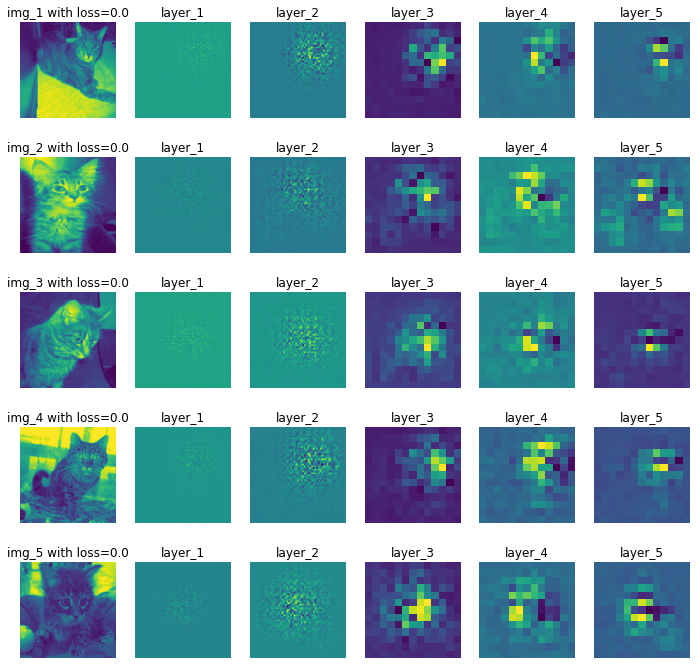

In [180]:
plot_deconvolutions(images_min_loss, min_losses, 5, 6)

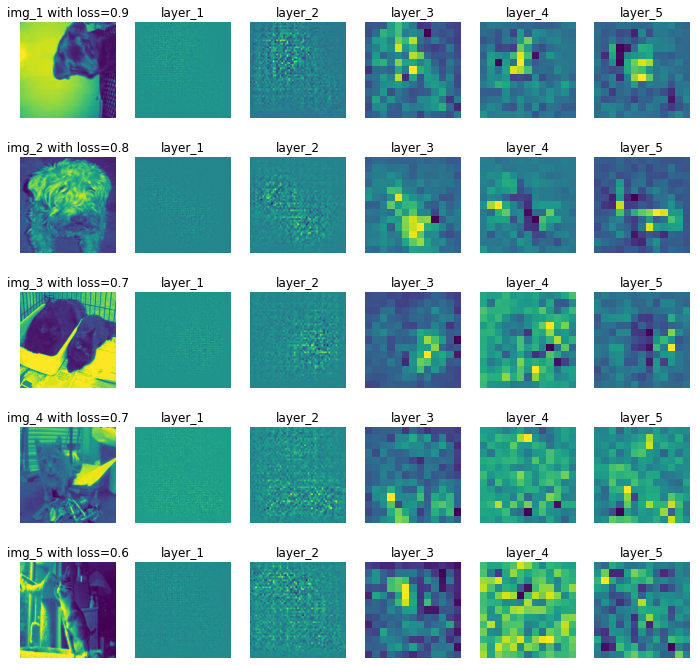

In [181]:
plot_deconvolutions(images_max_loss, max_losses, 5, 6)